## Closely follow 1023_method1_via_yasin.ipynb

### Imports

In [21]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Import necessary modules from dicomviewer
sys.path.append('/homebase/DL_projects/code_sync/myMedIADIRLab/third_party/dicomviewer/src')
from dicom_viewer.readers.RTStructReader import RTStructReader
from dicom_viewer.readers.DICOMImageReader import DICOMImageReader



In [14]:
# Define the path to the RT struct file
image_path     = "/database/brainmets/dicom/Data/SRS0871/1999-04__Studies/SRS0871_SRS0871_MR_1999-04-02_000000_._axial1_n47__00000"
rt_struct_path = "/database/brainmets/dicom/Data/SRS0871/1999-04__Studies/SRS0871_SRS0871_RTst_1999-04-02_000000_._Brain.MS.ReTx.Model_n1__00000"

# read dicom file
if os.path.exists(image_path):
    print(f"Dicom path exists: {image_path}")
    image_reader = DICOMImageReader(image_path, modality="MR")
    image_reader.read()
    print("Dicom file loaded successfully!")
else:
    print(f"Path does not exist: {image_path}")

# read rt struct file
if os.path.exists(rt_struct_path):
    print(f"RT struct path exists: {rt_struct_path}")
    
    # Initialize and load the RT struct reader
    rt_reader = RTStructReader(rt_struct_path)
    rt_reader.read()
    
    print("RT struct file loaded successfully!")
else:
    print(f"Path does not exist: {rt_struct_path}")


Dicom path exists: /database/brainmets/dicom/Data/SRS0871/1999-04__Studies/SRS0871_SRS0871_MR_1999-04-02_000000_._axial1_n47__00000
Dicom file loaded successfully!
RT struct path exists: /database/brainmets/dicom/Data/SRS0871/1999-04__Studies/SRS0871_SRS0871_RTst_1999-04-02_000000_._Brain.MS.ReTx.Model_n1__00000
RT struct file loaded successfully!


In [27]:
### Overview the structures
structure_names = rt_reader.get_structure_names()
print(f"Found {len(structure_names)} structures:")
for i, name in enumerate(structure_names):
    print(f"{i+1}. {name}")
## Which structure do I want to inspect
structure_name = "target1"
structure_index = rt_reader.get_structure_index(structure_name)

print(f"structure_name: {structure_name}, structure_index: {structure_index}")

contour_data = rt_reader.roi_contours[structure_index]

Found 5 structures:
1. target1
2. *Skull
3. 12.00 Gy (35.60% of dose)
4. Brain_target1
5. Brain-target1
structure_name: target1, structure_index: 0


In [28]:
print(contour_data)

(3006,002A) ROI Display Color                   IS: [255, 0, 0]
(3006,0040)  Contour Sequence  9 item(s) ---- 
   (3006,0016)  Contour Image Sequence  1 item(s) ---- 
      (0008,1150) Referenced SOP Class UID            UI: Secondary Capture Image Storage
      (0008,1155) Referenced SOP Instance UID         UI: 2.16.840.1.114362.1.12046989.25631758973.631597875.835.2172
      ---------
   (3006,0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
   (3006,0046) Number of Contour Points            IS: '26'
   (3006,0050) Contour Data                        DS: Array of 78 elements
   ---------
   (3006,0016)  Contour Image Sequence  1 item(s) ---- 
      (0008,1150) Referenced SOP Class UID            UI: Secondary Capture Image Storage
      (0008,1155) Referenced SOP Instance UID         UI: 2.16.840.1.114362.1.12046989.25631758973.631597875.836.2173
      ---------
   (3006,0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
   (3006,0046) Number of Contour Point

# Debug the original rasterizing code

In [29]:
mask_default = rt_reader.get_structure_mask(structure_name, image_reader)

print(mask_default.dtype, mask_default.shape)
print(np.min(mask_default), np.max(mask_default))

uint8 (47, 256, 256)
0 1


In [30]:
import SimpleITK as sitk
ct_array_shape = sitk.GetArrayFromImage(image_reader.image).shape  # (z, y, x)
print(ct_array_shape) # (47, 256, 256)
mask = np.zeros(ct_array_shape, dtype=np.uint8)

(47, 256, 256)


In [40]:
for ci, contour in enumerate(contour_data.ContourSequence):
    contour_points = np.array(contour.ContourData).reshape(-1, 3)  # (x, y, z) in mm
    print(contour_points.shape)

    print(contour_points)

    break

(26, 3)
[[115.67  147.67  -11.95 ]
 [115.964 147.377 -11.95 ]
 [118.312 147.377 -11.95 ]
 [118.606 147.67  -11.95 ]
 [118.9   147.964 -11.95 ]
 [119.193 148.258 -11.95 ]
 [119.487 148.551 -11.95 ]
 [119.78  148.845 -11.95 ]
 [119.78  150.606 -11.95 ]
 [119.487 150.9   -11.95 ]
 [119.193 151.193 -11.95 ]
 [118.9   151.487 -11.95 ]
 [118.606 151.78  -11.95 ]
 [118.312 152.074 -11.95 ]
 [116.551 152.074 -11.95 ]
 [116.257 151.78  -11.95 ]
 [115.964 151.487 -11.95 ]
 [115.377 151.487 -11.95 ]
 [115.083 151.193 -11.95 ]
 [115.083 150.606 -11.95 ]
 [114.789 150.313 -11.95 ]
 [114.496 150.019 -11.95 ]
 [114.496 148.845 -11.95 ]
 [114.789 148.551 -11.95 ]
 [115.083 148.258 -11.95 ]
 [115.377 147.964 -11.95 ]]


In [43]:
for ci, contour in enumerate(contour_data.ContourSequence):
    contour_points = np.array(contour.ContourData).reshape(-1, 3)  # (x, y, z) in mm
    print(f"Contour {ci}: {contour_points.shape[0]} points")
    print(f"Contour points shape: {contour_points.shape}")
    print(f"\nContour points:\n{contour_points}")

    # Compute distances between adjacent points
    num_points = contour_points.shape[0]
    distances = np.zeros(num_points)
    
    # Compute distances: 1-2, 2-3, ..., (n-1)-n
    for i in range(num_points - 1):
        distances[i] = np.linalg.norm(contour_points[i+1] - contour_points[i])
    
    # Compute distance from last point to first point (wrapping): n-1
    distances[num_points - 1] = np.linalg.norm(contour_points[0] - contour_points[num_points - 1])
    
    print(f"\nDistances between adjacent points (in mm):")
    print(f"Total number of distances: {len(distances)}")
    for i in range(num_points):
        if i < num_points - 1:
            print(f"  Point {i+1} to {i+2}: {distances[i]:.4f} mm")
        else:
            print(f"  Point {i+1} to 1 (wrapping): {distances[i]:.4f} mm")
    
    print(f"\nDistance statistics:")
    print(f"  Min distance: {np.min(distances):.4f} mm")
    print(f"  Max distance: {np.max(distances):.4f} mm")
    print(f"  Mean distance: {np.mean(distances):.4f} mm")
    print(f"  Std distance: {np.std(distances):.4f} mm")
    print(f"\nDistance array: {distances}")

    break

Contour 0: 26 points
Contour points shape: (26, 3)

Contour points:
[[115.67  147.67  -11.95 ]
 [115.964 147.377 -11.95 ]
 [118.312 147.377 -11.95 ]
 [118.606 147.67  -11.95 ]
 [118.9   147.964 -11.95 ]
 [119.193 148.258 -11.95 ]
 [119.487 148.551 -11.95 ]
 [119.78  148.845 -11.95 ]
 [119.78  150.606 -11.95 ]
 [119.487 150.9   -11.95 ]
 [119.193 151.193 -11.95 ]
 [118.9   151.487 -11.95 ]
 [118.606 151.78  -11.95 ]
 [118.312 152.074 -11.95 ]
 [116.551 152.074 -11.95 ]
 [116.257 151.78  -11.95 ]
 [115.964 151.487 -11.95 ]
 [115.377 151.487 -11.95 ]
 [115.083 151.193 -11.95 ]
 [115.083 150.606 -11.95 ]
 [114.789 150.313 -11.95 ]
 [114.496 150.019 -11.95 ]
 [114.496 148.845 -11.95 ]
 [114.789 148.551 -11.95 ]
 [115.083 148.258 -11.95 ]
 [115.377 147.964 -11.95 ]]

Distances between adjacent points (in mm):
Total number of distances: 26
  Point 1 to 2: 0.4151 mm
  Point 2 to 3: 2.3480 mm
  Point 3 to 4: 0.4151 mm
  Point 4 to 5: 0.4158 mm
  Point 5 to 6: 0.4151 mm
  Point 6 to 7: 0.4151 mm

In [50]:

from skimage.draw import polygon2mask

verbose = True


slc_cnt = 0

# --- 1) Convert each contour to index space and group by slice --- #
for ci, contour in enumerate(contour_data.ContourSequence):
    contour_points = np.array(contour.ContourData).reshape(-1, 3)  # (x, y, z) in mm

    # Transform physical coordinates to voxel indices for this image
    indices = np.array(
        [image_reader.image.TransformPhysicalPointToIndex(tuple(pt)) for pt in contour_points]
    )  # (N, 3) in (i, j, k) ~ (x, y, z indices)

    # Swap x & y so indices[:,0] = row (y), indices[:,1] = col (x)
    indices[:, [1, 0]] = indices[:, [0, 1]]

    # All points for this contour should lie on the same slice (same k index)
    slice_index = np.unique(indices[:, 2])
    if len(slice_index) != 1:
        raise ValueError("Contour points do not lie on a single slice")
    slice_index = int(slice_index[0])


    # Convert indices to 2D for the slice
    points_2d = indices[:, :2]

    # Create a boolean mask for the contour
    slice_shape = mask[slice_index].shape
    slice_mask = polygon2mask(slice_shape, points_2d)

    print(f"ci: {ci}, slice_index: {slice_index}, np.sum(slice_mask): {np.sum(slice_mask)}")

    slc_cnt += np.sum(slice_mask)


    # plt.figure()
    # plt.imshow(slice_mask)
    # plt.title(str(slice_index))

    # Update the mask array with this slice mask
    mask[slice_index] = np.maximum(mask[slice_index], slice_mask.astype(np.uint8))

ci: 0, slice_index: 42, np.sum(slice_mask): 20
ci: 1, slice_index: 41, np.sum(slice_mask): 91
ci: 2, slice_index: 40, np.sum(slice_mask): 194
ci: 3, slice_index: 39, np.sum(slice_mask): 174
ci: 4, slice_index: 39, np.sum(slice_mask): 44
ci: 5, slice_index: 38, np.sum(slice_mask): 161
ci: 6, slice_index: 38, np.sum(slice_mask): 33
ci: 7, slice_index: 37, np.sum(slice_mask): 117
ci: 8, slice_index: 36, np.sum(slice_mask): 54


In [52]:
print(slc_cnt)
print(np.sum(mask))

888
886


(47, 256, 256)


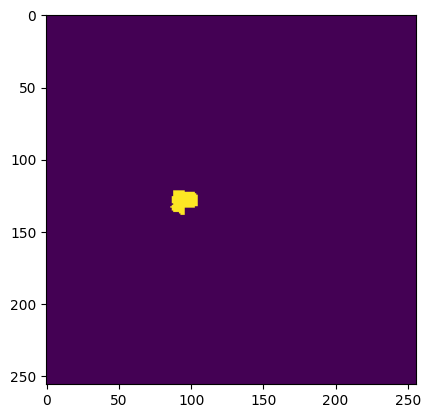

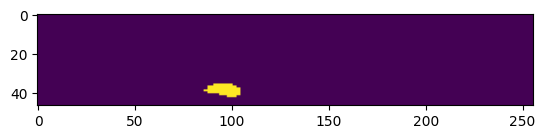

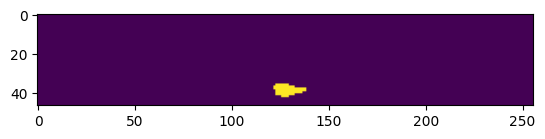

In [56]:
print(mask.shape)

plt.figure()
plt.imshow(np.max(mask, axis=0))

plt.figure()
plt.imshow(np.max(mask, axis=1))

plt.figure()
plt.imshow(np.max(mask, axis=2))

36
37
38
39
40
41
42


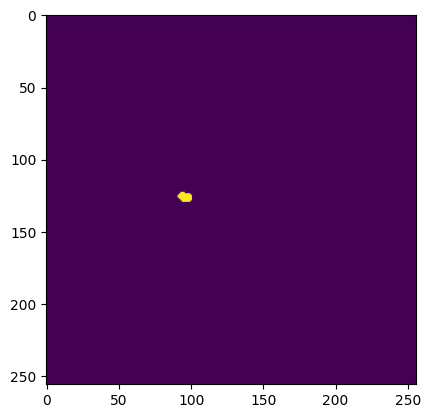

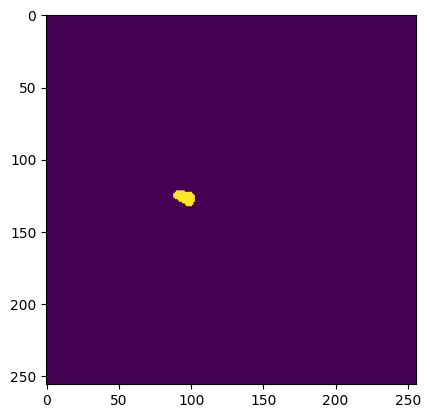

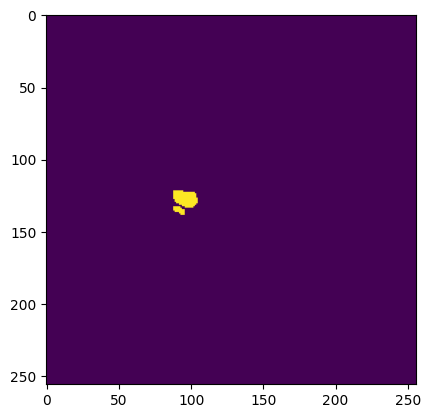

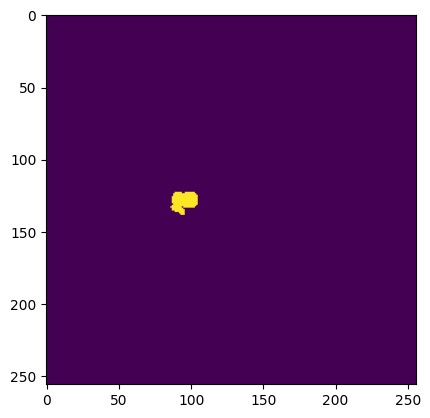

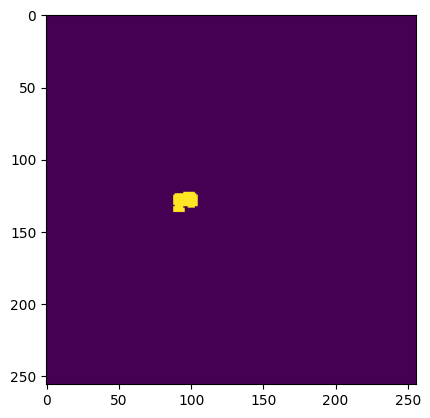

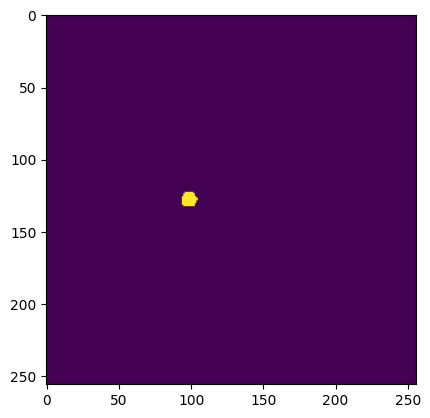

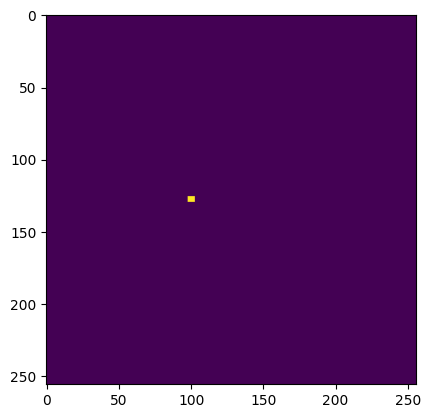

In [58]:
for slc_idx in range(36, 42+1):
    print(slc_idx)
    plt.figure()
    plt.imshow(mask[slc_idx,:,:])